# Building a convnet for ✊✋✌
This presents how to build a convnet from scratch to classify images of rock-paper-scissors.  It is meant as a teaching activity to demonstrate the following concepts in practice:
- how images are represented and handled in software
- how to prepare a machine learning dataset
- how a full machine learning pipeline looks
- data preprocessing
- data augmentation and its importance in a real ML task
- overfitting, underfitting

We use the high-level deep learning library Keras, but the concepts are general and we don't put much focus on the specifics of the code.

## Step 0: defining the problem
What problem do we want to solve, exactly?  We want to build a piece of software that, given an image as input that represents an hand making one of the three ✊✋✌ gestures, produces as output a classification of the image in one of the three classes.

In the following, we will adopt this convention
- class 0 is ✊ rock
- class 1 is ✋ paper
- class 2 is ✌ scissors

## Step 1: building a dataset
We are starting from scratch, so we need to shoot our own dataset; the best option is that multiple students/groups shoot plenty of images in parallel and then the data is somehow collected.  Whatever the process, in the end we want to have all pics in three different directories, one per class.  Format can be either jpg or png, and landscape/portrait, aspect ratio and resolution don't matter and can be mixed.

With some attention to logistics, this can be done in about 10-30 minutes.

Guidelines for shooting images. 
- We don't need high resolution: use the lowest resolution/quality allowed by the phone (this reduces the size of the dataset and speeds up data transfer).
- The hand must be more or less in the center of the image; it should not fill the whole image, but it should not be too small either.  ![caption](figures/guidelines.jpg)
- we want the dataset to represent as much variability as possible: if we want the classifier to work for all hand orientations, try to have examples for all of them; if we want to handle many different lightling conditions, try to have some pictures for different lightings;
- avoid poses that are ambiguous, unless you want to make your job harder: e.g., don't include in the dataset images of paper or scissors taken from the side;
- avoid having two images in the dataset that are almost the same: change the camera and hand pose at least a little bit; this is important because in the following code we randomly split training and testing data.

Remember that we need the images for each class to be in its own directory. To make this simpler, it helps to shoot first all images of rock, then all images of paper, then all images of scissors, and finally sort the images by time in the file manager and group them accordingly.

Place all images in three directories named `c0/`, `c1/`, and `c2/`.  Make sure that each directory only contains image files.

## Step 2: read in images and have a look at them
Let's first import what we need

In [1]:
%matplotlib inline

# General imports
import matplotlib.pyplot as plt
import pathlib
import skimage
import skimage.transform
import skimage.viewer
import pandas as pd
import numpy as np
import time
import keras.utils.np_utils
import warnings
from tqdm import tqdm

# Setup to show interactive jupyter widgets
from IPython.display import Image, display
from ipywidgets import interact, fixed
import ipywidgets as widgets

def imgplotList(i, data):
    plt.figure(figsize=(10, 10))
    plt.imshow(data[i], interpolation="nearest")
    plt.show()

/home/lale/anaconda3/envs/deep2/lib/python3.6/site-packages/skimage/viewer/utils/core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "
Using TensorFlow backend.


In [2]:
# Define where datasets are located
dataset_directory = pathlib.Path("..")/"datasets"/"final"

# Define which datasets we should consider.
# Each dataset is a directory withing dataset_directory
# and must contain three subdirectories: (c0, c1, c2) for (rock, paper, scissors).
dnames = ["D{}".format(n) for n in range(1,10)] + ["testing"]

# Now check the data
ddirs=[dataset_directory/dn for dn in dnames] # directories of the dataset
cdirs={}
for ddir in ddirs:
    cdirs.update({ddir/"c0":0,
                  ddir/"c1":1,
                  ddir/"c2":2})
names = ["rock", "paper", "scissors"]
for cdir,cdir_class in cdirs.items():
    assert(cdir.exists())
    print("Found directory {} containing class {}".format(cdir,names[cdir_class]))

Found directory ../datasets/final/D1/c0 containing class rock
Found directory ../datasets/final/D1/c1 containing class paper
Found directory ../datasets/final/D1/c2 containing class scissors
Found directory ../datasets/final/D2/c0 containing class rock
Found directory ../datasets/final/D2/c1 containing class paper
Found directory ../datasets/final/D2/c2 containing class scissors
Found directory ../datasets/final/D3/c0 containing class rock
Found directory ../datasets/final/D3/c1 containing class paper
Found directory ../datasets/final/D3/c2 containing class scissors
Found directory ../datasets/final/D4/c0 containing class rock
Found directory ../datasets/final/D4/c1 containing class paper
Found directory ../datasets/final/D4/c2 containing class scissors
Found directory ../datasets/final/D5/c0 containing class rock
Found directory ../datasets/final/D5/c1 containing class paper
Found directory ../datasets/final/D5/c2 containing class scissors
Found directory ../datasets/final/D6/c0 conta

Let's now read the first image from the first directory, and visualize it.  Note that the tool allows you to zoom in order to see the individual pixels.

In [3]:
im = skimage.io.imread(list(list(cdirs.keys())[-1].glob("*"))[0])
viewer=skimage.viewer.ImageViewer(im)
viewer.show()
# Note: you have to close the window to continue

[]

We now read in all images, cut the central square (with an edge as long as the shorter dimension), and resize it to 200x200 pixels.  Whatever the initial size and orientation of the images, we will end up with a bunch of 200x200 RGB squares in uint8.  These should be small enough that unless the dataset is huge, all should fit in memory.

We make a pandas dataframe with the data, with four columns:
* image: a $200 \times 200 \times 3$ uint8 numpy array
* label: on of 0, 1 or 2
* file: the full path of the image
* dn: the name of the directory the image comes from (will be useful later)

In [4]:
imagesize = 200
dataset = []

for cdir, cn in tqdm(list(cdirs.items())):
    for f in list(cdir.glob("*")):
        if f.name.startswith("."):
            continue
        try:
            im = skimage.io.imread(f)
        except (OSError, ValueError) as e:
            warnings.warn("ignoring {} due to exception {}".format(f, str(e)))
            continue

        h, w = im.shape[0:2]  # height, width
        sz = min(h, w)
        im = im[(h//2-sz//2):(h//2+sz//2),
                (w//2-sz//2):(w//2+sz//2), :]  # crops to the central square
        im = skimage.transform.resize(im, (imagesize, imagesize), mode="reflect", anti_aliasing=True)
        im = skimage.img_as_ubyte(im)

        dataset.append(dict(file=f, label=cn, image=im, dn=f.parent.parts[-2]))

print("Done")
dataset = pd.DataFrame(dataset)

  0%|          | 0/30 [00:00<?, ?it/s]/home/lale/anaconda3/envs/deep2/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
100%|██████████| 30/30 [00:50<00:00,  1.69s/it]

Done


Here are 3 random rows from that dataset

In [5]:
dataset.sample(n=3).style

,dn,file,image,label
106,D1,../datasets/final/D1/c2/IMG_20170315_110129.jpg,[[[ 88 84 85] [ 89 86 85] [ 91 87 86] ... [ 0 0 0] [ 0 0 0] [ 0 0 0]] [[ 85 84 84] [ 89 88 86] [ 88 87 85] ... [ 0 0 0] [ 0 0 0] [ 0 0 0]] [[ 87 87 87] [ 87 87 85] [ 87 87 85] ... [ 0 0 0] [ 1 1 1] [ 1 1 1]] ... [[117 116 114] [119 118 116] [121 117 116] ... [138 134 131] [137 133 132] [137 133 132]] [[120 118 115] [122 119 117] [123 118 117] ... [134 132 128] [135 132 130] [135 132 131]] [[119 117 113] [121 117 114] [122 117 114] ... [133 132 128] [136 133 131] [137 134 131]]],2
752,D5,../datasets/final/D5/c1/20140828_183854.jpg,[[[155 145 135] [154 144 135] [157 147 138] ... [127 40 48] [117 43 44] [118 42 44]] [[156 147 136] [157 148 138] [157 148 139] ... [119 42 49] [117 43 51] [120 39 52]] [[157 149 136] [157 149 138] [158 150 138] ... [122 59 65] [121 43 50] [121 38 47]] ... [[169 163 161] [169 164 163] [171 165 165] ... [174 160 177] [171 157 175] [156 141 160]] [[169 162 163] [168 163 164] [170 165 166] ... [165 151 167] [153 139 156] [140 126 143]] [[169 160 163] [167 162 164] [167 162 163] ... [159 145 162] [142 128 145] [125 111 128]]],1
1951,D8,../datasets/final/D8/c1/20180327130419-Paper-fd3b563d3a42d605.jpg,[[[190 202 201] [189 202 201] [189 203 203] ... [177 201 213] [177 200 211] [178 200 209]] [[190 202 202] [190 201 202] [188 203 202] ... [177 202 214] [177 200 212] [177 200 211]] [[189 202 202] [189 201 201] [188 203 203] ... [177 202 213] [179 203 215] [178 202 214]] ... [[131 134 125] [130 135 128] [131 135 128] ... [ 87 90 83] [ 86 89 82] [ 86 88 81]] [[131 134 127] [130 134 127] [131 135 128] ... [ 88 91 84] [ 85 87 81] [ 85 87 81]] [[129 132 124] [130 133 127] [132 134 129] ... [ 88 91 85] [ 87 90 82] [ 87 89 83]]],1


Optionally, we can quickly scroll through the images in our dataset.

In [6]:
viewer = skimage.viewer.CollectionViewer([r[1]["image"] for r in dataset.sort_values("dn").iterrows()])
viewer.show()
# Note: you have to close the window to continue

[]

## Step 3: Prepare training and testing sets

How should we split training and testing data? **This is a key choice in real ML deployments!**

In [7]:
# Test on all samples from one specific dataset
te_mask = dataset["dn"]=="D7"
dataset_te=dataset[te_mask]

In [8]:
# In any case, training samples are all other samples
dataset_tr = dataset.loc[dataset.index.difference(dataset_te.index)]

# Print a summary of how many training and testing images we have sampled
import collections
pd.DataFrame(index=[0,1,2],data=collections.OrderedDict((
    ("Class name",           names),
    ("# Training images", dataset_tr["label"].value_counts()),
    ("# Testing images",  dataset_te["label"].value_counts())))).set_index("Class name")

,# Training images,# Testing images
Class name,,
rock,642,176
paper,617,175
scissors,663,169


## Step 4: define what we feed to the Neural Network

In [9]:
im = dataset_tr.sample(1).iloc[0]["image"]
print(im.shape, im.dtype)
im

(200, 200, 3) uint8


array([[[ 86,  72,  59],
        [ 91,  77,  64],
        [ 90,  76,  63],
        ...,
        [102,  92,  82],
        [103,  92,  81],
        [102,  90,  78]],

       [[ 92,  78,  65],
        [ 89,  75,  62],
        [ 93,  79,  66],
        ...,
        [100,  90,  80],
        [102,  91,  80],
        [104,  92,  81]],

       [[ 95,  81,  68],
        [ 93,  79,  66],
        [ 93,  79,  66],
        ...,
        [ 99,  89,  79],
        [103,  91,  82],
        [102,  90,  80]],

       ...,

       [[104,  88,  75],
        [106,  90,  75],
        [108,  92,  77],
        ...,
        [ 86,  56,  44],
        [ 86,  57,  46],
        [ 89,  61,  50]],

       [[105,  90,  77],
        [108,  92,  78],
        [108,  91,  77],
        ...,
        [ 87,  58,  45],
        [ 89,  60,  49],
        [ 94,  65,  54]],

       [[106,  91,  78],
        [103,  87,  74],
        [108,  90,  76],
        ...,
        [ 90,  61,  49],
        [ 88,  58,  45],
        [ 95,  65,  54]]

In [10]:
# Take image and resize to a specified size
def transform_simple(im,sz):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        imr = skimage.transform.resize(im, (sz,sz))
    return imr

transform = transform_simple

In [22]:
# Take image and resize to a specified size, after applying data augmentation
def transform_complex(im,sz):
    if(np.random.rand()<0.5):
        im=np.fliplr(im)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tf1 = skimage.transform.SimilarityTransform(scale = 1 / im.shape[0])
        tf2 = skimage.transform.SimilarityTransform(translation=[-0.5, -0.5])
        tf3 = skimage.transform.SimilarityTransform(rotation=np.deg2rad(np.random.uniform(0,360)))
        tf4 = skimage.transform.SimilarityTransform(scale=np.random.uniform(1,1.6))
        tf5 = skimage.transform.SimilarityTransform(translation=np.array([0.5, 0.5])+np.random.uniform(-0.1,0.1,size=2))
        tf6 = skimage.transform.SimilarityTransform(scale=sz)
        imr = skimage.transform.warp(im, (tf1+(tf2+(tf3+(tf4+(tf5+tf6))))).inverse, output_shape=(sz,sz),mode="edge")
        imr = imr*np.random.uniform(0.9,1.1,size=(1,1,3))
        imr = np.clip(imr,0,1)
    return imr

transform = transform_complex

In [11]:
# The resolution challenge
@interact(sz = widgets.IntSlider(min=2,max=100),
          seed = widgets.IntSlider(min=0,max=100),
          reveal = widgets.widgets.ToggleButton(value=False,description='Reveal'))
def f(sz,seed,reveal):
    fig,axs = plt.subplots(nrows = 2, ncols = 5,figsize=(6,3),dpi=150)
    ims = dataset_tr.sample(len(axs.flatten()), random_state=sz*100+seed)
    for ax,(_,row) in zip(axs.flatten(),ims.iterrows()):
        ax.imshow(transform_simple(row["image"],sz))
        ax.axis("off")
        if(reveal):
            ax.set_title(names[row["label"]])
    #fig.tight_layout()

interactive(children=(IntSlider(value=2, description='sz', min=2), IntSlider(value=0, description='seed'), Tog…

In [12]:
def sample(df,sz):
    r = df.sample(n=1)
    l = r["label"].iloc[0]
    im = r["image"].iloc[0]
    im = transform(im,sz)
    return im,l

def mkbatch(df,N,sz):
    X = []
    y = []
    for i in range(N):
        im,l = sample(df,sz)
        X.append(im)
        y.append(l)
    X = np.array(X).astype('float32')
    y = np.array(y)
    y = keras.utils.np_utils.to_categorical(y,3)
    return X,y

def generator(df,batch_size,sz):
    while True:
        X,y = mkbatch(df,batch_size,sz)
        yield (X,y)

In [ ]:
# What is a batch exactly?
b = mkbatch(dataset_tr, 3, 2)
b

In [13]:
# Visualize 100 images from our input dataset
examples = list(mkbatch(dataset_tr, 100, 32)[0])
interact(imgplotList, i=widgets.IntSlider(min=0, max=len(examples)-1, step=1, value=0,continuous_update=False), data=fixed(examples))

interactive(children=(IntSlider(value=0, continuous_update=False, description='i', max=99), Output()), _dom_cl…

<function __main__.imgplotList(i, data)>

In [ ]:
# Visualize 100 variations from our first input image (makes sense only if transform==transform_complex, i.e. if we are using data augmentation)
examples = list(mkbatch(dataset_tr.iloc[[0]],100,32)[0])
interact(imgplotList, i=widgets.IntSlider(min=0, max=len(examples)-1, step=1, value=0,continuous_update=False), data=fixed(examples))

## Step 5: build and train the neural network
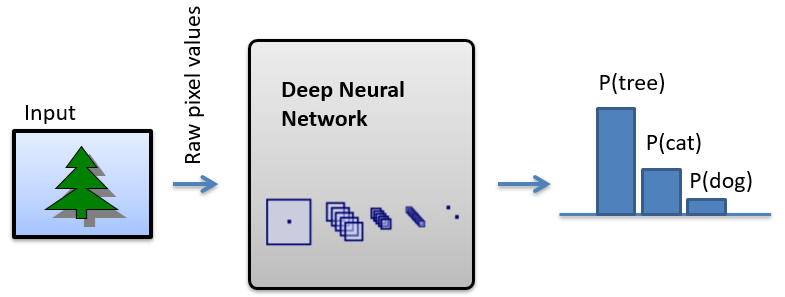

In [16]:
import keras
from keras.utils  import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dropout

### An easy model first...
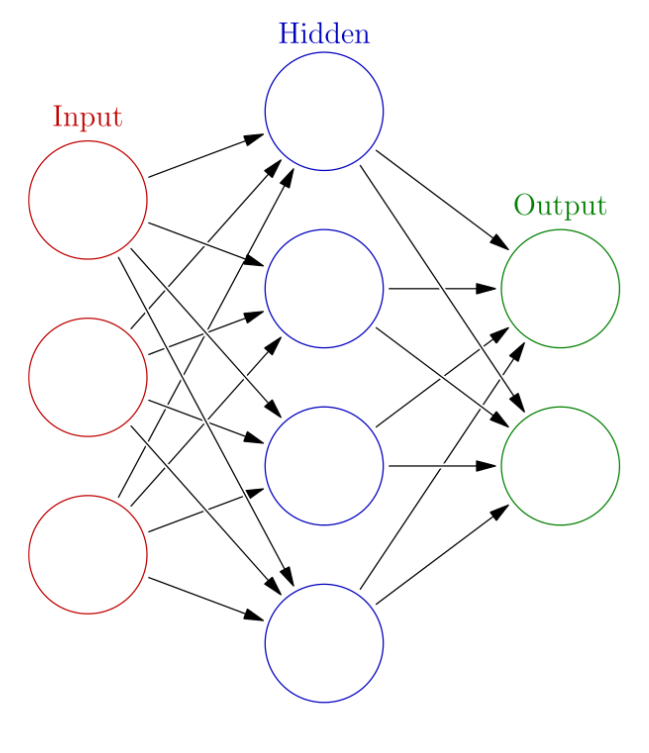

In [ ]:
model = Sequential()
model.add(Dense(4, input_shape=(3,)))
model.add(Dense(2))
model.summary()

### And now the real stuff
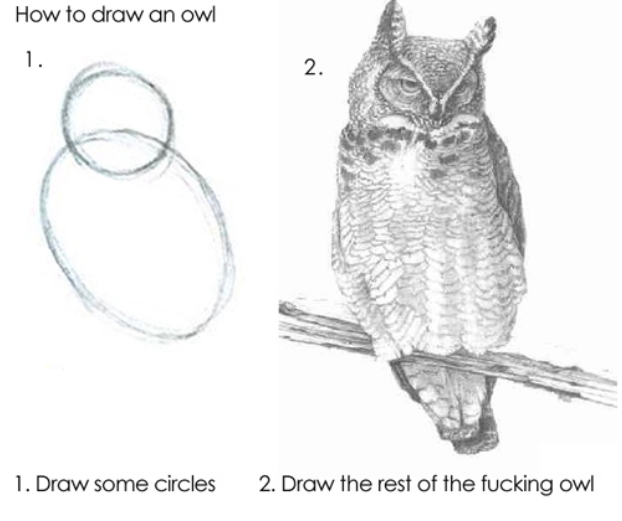

In [17]:
# NN settings
patchsize          = 32
batch_size         = 32
pool_size          = (2,2) # size of pooling area for max pooling
kernel_size        = (3,3) # convolution kernel size

def makeModel(nb_filters):
    model = Sequential()
    model.add(Conv2D(nb_filters, kernel_size, input_shape=(patchsize,patchsize,3), padding = "same"))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = pool_size))
    model.add(Conv2D(nb_filters*2, kernel_size, padding = "same"))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = pool_size))
    model.add(Conv2D(nb_filters*4, kernel_size, padding = "same"))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = pool_size))
    model.add(AveragePooling2D(pool_size = pool_size))
    model.add(Flatten())
    model.add(Dense(128)) # generate a fully connected layer wiht 128 outputs (arbitrary value)
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3)) # output layer
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [18]:
makeModel(16).summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          18496     
__________

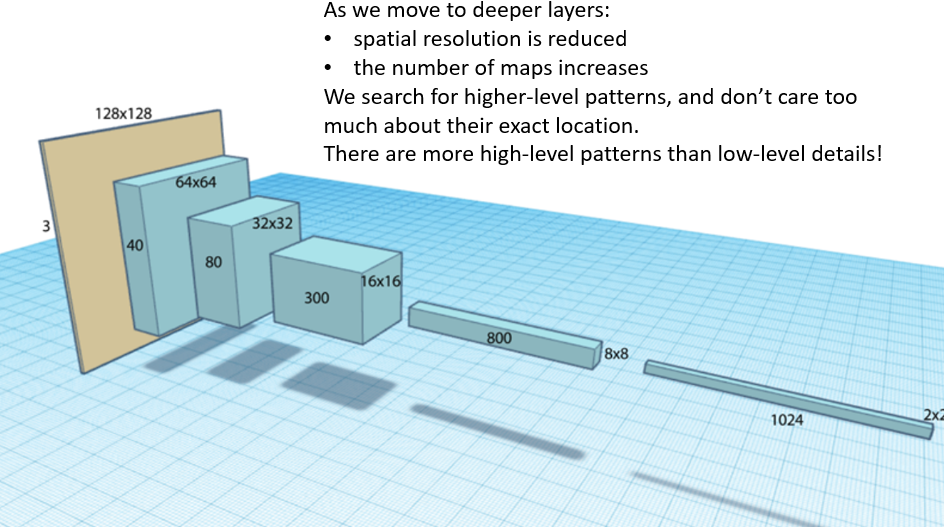

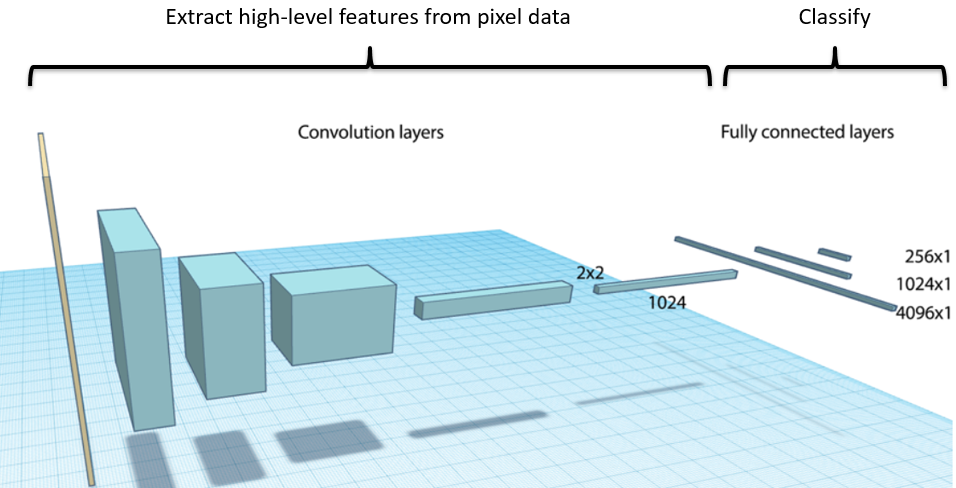

### We want to monitor our network while it trains
so we build a set of 1000 instances taken from the testing dataset.

Note: "testing" in this case is synonym with "validation" and "evaluation"

In [19]:
(X_test,y_test) = mkbatch(dataset_te, 1000, patchsize)

# Prepare the logs directory, if it does not exist
(pathlib.Path(".")/"logs").mkdir(exist_ok=True)

While the network trains, we can monitor training loss/accuracy and testing loss/accuracy using tensorboard at http://0.0.0.0:6006

You may need to launch tensorboard first if it's not already running, by executing

`tensorboard --logdir=logs`

in a shell with the current working directory.  Check that you are within the proper conda environment, if applicable.

In [23]:
modelid = time.strftime("%Y%m%d%H%M%S")

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_acc',
        patience=50),
    keras.callbacks.ModelCheckpoint(
        filepath='model_checkpoint_best_{}.h5'.format(modelid),
        monitor='val_loss',
        save_best_only=True),
    keras.callbacks.TensorBoard(
        log_dir='./logs/'+modelid,
        histogram_freq=0, write_graph=False, write_images=False)
]

model = makeModel(32)
history=model.fit_generator(
                    generator(dataset_tr, batch_size, patchsize),
                    steps_per_epoch=50, 
                    epochs=150, 
                    verbose=1,
                    validation_data=(X_test,y_test),
                    callbacks=callbacks_list)

Epoch 1/150
50/50 [==============================] - 5s 105ms/step - loss: 1.1011 - acc: 0.3481 - val_loss: 1.0986 - val_acc: 0.3150
Epoch 2/150
50/50 [==============================] - 21s 413ms/step - loss: 1.0982 - acc: 0.3519 - val_loss: 1.0971 - val_acc: 0.3670
Epoch 3/150
50/50 [==============================] - 6s 111ms/step - loss: 1.0934 - acc: 0.3525 - val_loss: 1.0956 - val_acc: 0.3610
Epoch 4/150
50/50 [==============================] - 8s 155ms/step - loss: 1.0932 - acc: 0.3556 - val_loss: 1.1230 - val_acc: 0.3150
Epoch 5/150
50/50 [==============================] - 15s 304ms/step - loss: 1.0925 - acc: 0.3781 - val_loss: 1.1002 - val_acc: 0.3610
Epoch 6/150
50/50 [==============================] - 12s 243ms/step - loss: 1.1011 - acc: 0.3294 - val_loss: 1.0990 - val_acc: 0.3150
Epoch 7/150
50/50 [==============================] - 11s 223ms/step - loss: 1.0981 - acc: 0.3550 - val_loss: 1.1033 - val_acc: 0.3150
Epoch 8/150
50/50 [==============================] - 4s 80ms/step

50/50 [==============================] - 3s 68ms/step - loss: 0.5959 - acc: 0.7706 - val_loss: 0.9082 - val_acc: 0.6030
Epoch 63/150
50/50 [==============================] - 3s 68ms/step - loss: 0.5599 - acc: 0.7800 - val_loss: 0.9093 - val_acc: 0.6440
Epoch 64/150
50/50 [==============================] - 3s 68ms/step - loss: 0.5783 - acc: 0.7769 - val_loss: 0.9354 - val_acc: 0.6400
Epoch 65/150
50/50 [==============================] - 4s 71ms/step - loss: 0.5908 - acc: 0.7594 - val_loss: 0.8741 - val_acc: 0.6610
Epoch 66/150
50/50 [==============================] - 3s 68ms/step - loss: 0.6050 - acc: 0.7600 - val_loss: 0.9785 - val_acc: 0.5760
Epoch 67/150
50/50 [==============================] - 4s 71ms/step - loss: 0.5773 - acc: 0.7769 - val_loss: 0.9377 - val_acc: 0.6350
Epoch 68/150
50/50 [==============================] - 4s 71ms/step - loss: 0.5557 - acc: 0.7806 - val_loss: 0.8505 - val_acc: 0.6580
Epoch 69/150
50/50 [==============================] - 3s 68ms/step - loss: 0.5359 

50/50 [==============================] - 3s 69ms/step - loss: 0.3707 - acc: 0.8612 - val_loss: 0.8315 - val_acc: 0.7020
Epoch 124/150
50/50 [==============================] - 3s 68ms/step - loss: 0.3880 - acc: 0.8544 - val_loss: 0.8265 - val_acc: 0.7000
Epoch 125/150
50/50 [==============================] - 3s 68ms/step - loss: 0.3674 - acc: 0.8606 - val_loss: 0.7779 - val_acc: 0.6810
Epoch 126/150
50/50 [==============================] - 4s 72ms/step - loss: 0.4180 - acc: 0.8325 - val_loss: 0.8744 - val_acc: 0.7010
Epoch 127/150
50/50 [==============================] - 3s 69ms/step - loss: 0.3883 - acc: 0.8519 - val_loss: 0.8757 - val_acc: 0.6910
Epoch 128/150
50/50 [==============================] - 3s 69ms/step - loss: 0.3581 - acc: 0.8713 - val_loss: 0.7795 - val_acc: 0.7070
Epoch 129/150
50/50 [==============================] - 3s 69ms/step - loss: 0.3904 - acc: 0.8481 - val_loss: 0.8420 - val_acc: 0.6950
Epoch 130/150
50/50 [==============================] - 3s 69ms/step - loss: 

After training our model, we can save it to disk

In [ ]:
modelname = "input32"

# Save model to a file
keras.models.save_model(model,"{}.model".format(modelname))

# Also save the testing dataset (may be large) so we can pick up from here later 
dataset_te.to_pickle("{}.testingdata.pickle".format(modelname))

## Step 6: Process the images of the testing set one by one
And visualize the results

In [ ]:
# Optionally, load a saved model and testing dataset
modelname = "models/model_venus"

model = keras.models.load_model("{}.model".format(modelname))
patchsize = model.input.shape[1].value
dataset_te = pd.read_pickle("{}.testingdata.pickle".format(modelname))

In [24]:
# Show results by processing a single variation of the testing image
import warnings

%matplotlib inline
def resultsShow(i, data, model):
    d = data.iloc[i]
    im = d["image"]
    l = d["label"]
    fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(15,5),gridspec_kw={'width_ratios':[1,1,0.5]})
    
    imt = transform_simple(im, patchsize)
    axs[0].imshow(im)
    axs[0].set_title("Image (true class: {})".format(names[l]))
    
    axs[1].imshow(imt,interpolation="nearest")
    axs[1].set_title("Network input")
    
    outs = model.predict(np.array([imt]))
    print(outs)
    predicted = np.argmax(outs)
    axs[2].bar(np.array(range(len(names))), outs[0,:], 1, color="gray")
    axs[2].set_ylim([0,1])
    axs[2].set_xticks(range(len(names)))
    axs[2].set_xticklabels(names)
    axs[2].set_ylabel("probability")
    axs[2].set_xlabel("class")
    axs[2].set_title("Network output")
    fig.tight_layout()
    plt.show()
    fig.savefig("out_{:05d}_{}.png".format(i,("ok" if predicted==l else "ko")))
    print(outs)

interact(resultsShow, i=widgets.IntSlider(min=0,max=len(dataset_te)-1, step=1, value=0, continuous_update=False), data=fixed(dataset_te.sample(len(dataset_te))), model=fixed(model))


interactive(children=(IntSlider(value=0, continuous_update=False, description='i', max=519), Output()), _dom_c…

<function __main__.resultsShow(i, data, model)>

# Back to powerpoint!

In [ ]:
# Show results by processing a single variation of the testing image
import warnings

dataset_te_new = dataset.loc[dataset.dn == "new"]
tdata = dataset_te_new.iloc[1:,:]

%matplotlib inline
def resultsShow(i, data, model):
    d = data.iloc[i]
    im = d["image"]
    l = d["label"]
    fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(10,4),
                           gridspec_kw={'width_ratios':[1,1,0.5]}, dpi=200)
    
    imt = transform_simple(im, patchsize)
    axs[0].imshow(im)
    axs[0].set_title("Image (true class: {})".format(names[l]))
    
    axs[1].imshow(imt,interpolation="nearest")
    axs[1].set_title("Network input")
    
    for ax in axs[:2]:
        ax.set(xticks=[], yticks=[])
    
    outs = model.predict(np.array([transform_complex(im, patchsize) for _ in range(100)]))
    outs = np.mean(outs, axis=0)[np.newaxis,:]
    predicted = np.argmax(outs)
    axs[2].bar(np.array(range(len(names))), outs[0,:], 1, color="gray")
    axs[2].set_ylim([0,1])
    axs[2].set_xticks(range(len(names)))
    axs[2].set_xticklabels(names)
    axs[2].set_ylabel("probability")
    axs[2].set_xlabel("class")
    axs[2].set_title("Network output")
    fig.tight_layout()
    fig.savefig("out_new_{:05d}.png".format(i))
    plt.show()
    
interact(resultsShow, i=widgets.IntSlider(min=0,max=len(tdata)-1, step=1, value=0, continuous_update=False), data=fixed(tdata), model=fixed(model));

In [ ]:
# Save processed variations
import warnings
import itertools
outdir = pathlib.Path("out")
if(not outdir.exists()):
    outdir.mkdir()
for i,j in itertools.product(range(len(dataset_te_new)),range(20)):
    d = dataset_te_new.iloc[i,:]
    im = d["image"]
    l = d["label"]
    fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(10,4),
                           gridspec_kw={'width_ratios':[1,1,0.5]}, dpi=200)
    imt = transform_complex(im, patchsize)
    axs[0].imshow(im)
    axs[0].set_title("Image (true class: {})".format(names[l]))

    axs[1].imshow(imt,interpolation="nearest")
    axs[1].set_title("Network input")

    for ax in axs[:2]:
        ax.set(xticks=[], yticks=[])

    outs = model.predict(np.array([imt]))
    predicted = np.argmax(outs)
    axs[2].bar(np.array(range(len(names))), outs[0,:], 1, color="gray")
    axs[2].set_ylim([0,1])
    axs[2].set_xticks(range(len(names)))
    axs[2].set_xticklabels(names)
    axs[2].set_ylabel("probability")
    axs[2].set_xlabel("class")
    axs[2].set_title("Network output")
    fig.tight_layout()
    fig.savefig(str(outdir/"out_new_{:05d}_aug_{:05d}.png".format(i,j)))
    plt.close(fig)

## Visualize the filters learned by the NN

In [ ]:
model.summary()

In [ ]:
model.layers[0].get_weights()[0][:,:,1,0]

In [ ]:
# Visualize filters in a layer
import itertools
filters = model.layers[2].get_weights()[0]
filters.shape
fig, axs = plt.subplots(nrows = filters.shape[2], ncols = filters.shape[3], figsize=(20,10))
for i,j in itertools.product(range(filters.shape[2]),range(filters.shape[3])):
    axs[i,j].imshow(filters[:,:,i,j],vmin=-0.5,vmax=+0.5,cmap="gray")
    axs[i,j].axis("off")

## Visualize the activations in the intermediate layers

In [ ]:
from keras import backend as K

def plot_hidden_layers(imt,nmaps=4):
    fig = plt.figure(figsize=(15, 10))
    plt.title('Hidden layers', loc='center')
    plt.axis('off')
    layers = [model.layers[0].input] + [model.layers[i].output for i in [0,2,5,7,9]]
    for layeri,layer in enumerate(layers):
        get = K.function([model.layers[0].input], [layer])
        layeroutputs = get([imt[np.newaxis,:,:,:]])[0][0]
        for j in range(nmaps): # for each map
            sp2=fig.add_subplot(nmaps,len(layers),layeri+1+j*len(layers))
            sp2.axis('off')
            if (layeroutputs.shape[2]>j):
                vmin,vmax = ((0,1) if layeri == 0 else (-0.3,+0.3))
                sp2.imshow(layeroutputs[:,:,j],
                           cmap="gray",
                           interpolation="nearest")
    fig.tight_layout()

imt=transform(dataset_te["image"].iloc[0],patchsize)
plot_hidden_layers(imt)


## We now search for the inputs maximizing a given neuron or set of neurons

In [ ]:
model.summary()

In [ ]:
def makeinputmaximizing(loss, gradstep = 0.01, steps = 20):
    grads = K.gradients(loss, model.input)[0]
    grads /= K.sqrt(K.mean(K.square(grads)) + 1e-5)
    iterate = K.function([model.input, K.learning_phase()],[loss, grads])

    # img = transform_simple(dataset_te["image"].iloc[0],patchsize)[np.newaxis,:,:,:]
    img = 0.5+0.01*np.random.rand(1,patchsize,patchsize,3)
    
    for i in range(steps):
        loss_value, grads_value = iterate([img, 1])     
        img += grads_value * gradstep
        img = np.clip(img,0,1)
    return img[0,:,:,:]

In [ ]:
plt.imshow(makeinputmaximizing(model.layers[6].output[0,2], steps = 1000, gradstep = 0.1))

In [ ]:
import tqdm
out = model.layers[6].output
fig, axs = plt.subplots(nrows = 2, ncols = 5, figsize=(20,5), squeeze = False)
for i,j in tqdm.tqdm(list(itertools.product(range(axs.shape[0]), range(axs.shape[1])))):
    loss = K.mean(out[:,j])
    img = makeinputmaximizing(loss, gradstep = 0.03, steps = 20)
    axs[i,j].imshow(img)
    axs[i,j].axis("off")

## Let us look for what the convnet considers an ideal instance of a class

In [ ]:
final_output = [makeinputmaximizing(model.output[0,k], gradstep=0.02, steps=50) for k in range(3)]
fig,ax = plt.subplots(figsize=(15,5))
ax.imshow(np.hstack(final_output))

## Let us try to locate the gesture in the image
- First, we feed an image of a paper gesture to the network;
- Second, we assign to each channel in the output of the last convolution a value corresponding ot its contribution to the class "paper";
- Third, we consider which parts in the input image activate the channels that lead to the decision: this is a paper. 

In [ ]:
import cv2

img=skimage.img_as_float(skimage.io.imread("paper.jpg"))
img=np.expand_dims(img, axis=0)

preds=model.predict(img)
rps_output=model.output[:, np.argmax(preds[0])]
last_conv_layer=model.layers[6]
grads=K.gradients(rps_output, last_conv_layer.output)[0]
pooled_grads=K.mean(grads, axis=(0, 1, 2))

iterate=K.function([model.input, K.learning_phase()], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([img, 1])
##
for i in range(384):
    conv_layer_output_value[:,:,i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
heatmap=cv2.resize(heatmap, (img.shape[1], img.shape[2]))
plt.imshow(heatmap)
print(heatmap[8])

img=skimage.img_as_float(skimage.io.imread("paper.jpg"))
heatmap=np.expand_dims(heatmap, axis=3)
superimposed_img= np.clip(img + heatmap * 0.3 , 0, 1)
plt.imshow(superimposed_img)
